# Basic Model Testing

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

# Loading the Dataset

In [2]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib') # Add library folder
#print(sys.path)

In [3]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [4]:
Dataset = get_dataset('coco', 'ctdet')

# Initializing opt

In [5]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

In [6]:
#opt.keep_res = True

Create opt for passing to the constructor. \
Also pass a string with the training value

# Loading Full Dataset

In [7]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=15.45s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Loaded val 5000 samples


## Modifying dataset

For initial testing we are modifying the dataset to a smaller size. The following code updates the json file list to use a smalller subset of the data. 

In [8]:
all_Ids=dataset.coco.getImgIds()
all_Ids2=valset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir=sys.path[0]+'/../../data/coco/train2017/'

118287


In [9]:
def myimshow(image, ax=plt):
    #image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image)
    ax.axis('off')
    return h

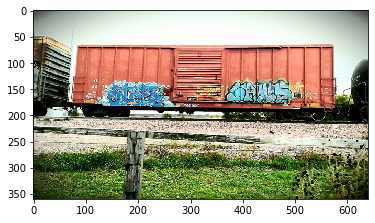

In [10]:
img = dataset.coco.loadImgs(dataset.images[257])[0]
f_name=img_dir
f_name+=img['file_name']
I = io.imread(f_name)
plt.figure()
plt.imshow(I)
plt.show()

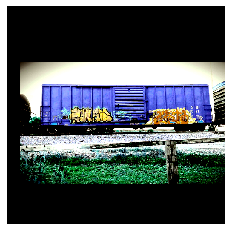

In [11]:
ret = dataset.__getitem__(257)
myimshow(ret['input'])
plt.show()

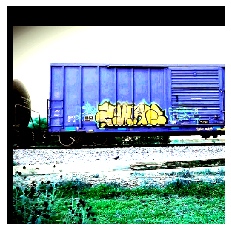

In [12]:
ret = dataset.__getitem__(257)
myimshow(ret['input'])
plt.show()

In [13]:
print(ret['input'].shape,I.shape)

(3, 512, 512) (360, 640, 3)


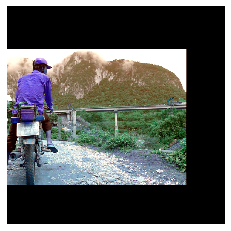

In [14]:
ret = dataset.__getitem__(0)
myimshow(ret['input'])
plt.show()

In [15]:
M=512
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids2))
    tmp=imgIds_perm[0:M].astype(int)
    tmp2=[all_Ids2[t] for t in tmp]
    valset.images=tmp2
    valset.num_samples=len(valset.images)
np.random.seed(2)

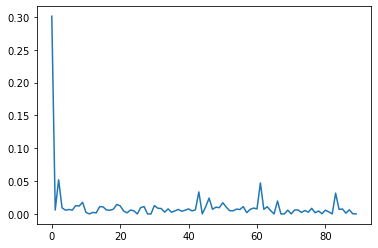

In [16]:
N=2048
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [17]:
np.random.seed(0)
np.random.permutation(5)

array([2, 0, 1, 3, 4])

In [18]:
opt.num_iters = dataset.num_samples/opt.batch_size
#print(dataset.images)

# Model

In [19]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [20]:
# regression on center point.
model = create_model(opt.arch, opt.heads, opt.head_conv)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [21]:
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

# Centernet_model Class

In [22]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt

In [23]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
               if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    param.data += 5e-2*torch.randn(param.size()).to(opt.device) # Random initialization
               else: 
                    param.requires_grad=False
            #print(name,param.requires_grad)
        self.model=model
        self.model_with_loss.model = model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

# Trainer

In [24]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [25]:
model =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');

loaded /datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


## Verification

In [26]:
#for name,param in net.model.named_parameters():
#    print(name,param.size(),param.requires_grad)

# Experiment: Change Regularization Loss to smooth-$l_1$

In [27]:
trainer = CtdetTrainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)
net_sl1 = Centernet_model(opt,model);
net_sl1 = net_sl1.to(opt.device)
adam = torch.optim.Adam(net_sl1.parameters(), lr=opt.lr)
stats_manager = nt.StatsManager()
exp_reg_loss_sl1 = nt.Experiment(net_sl1,dataset,valset,adam,stats_manager,
output_dir="Experiment_perturbation_2000_samples_v2",batch_size=opt.batch_size,perform_validation_during_training=False)

In [ ]:
exp_reg_loss_sl1.run2(num_epochs=201)

In [ ]:
print(exp_reg_loss_sl1.history)

In [ ]:
plt.figure(1)
plt.plot(exp_reg_loss_sl1.history,label='MSE Reg Loss')
plt.legend()
plt.show()

In [ ]:
print(exp_reg_loss_sl1.evaluate2())

# Testing: Basic Case

In [29]:
print(opt.task)

ctdet


Create Detector object: Loads model from their library

In [30]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
opt.K = 100
opt.vis_thresh = 0.3

In [31]:
from detectors.ctdet import CtdetDetector
opt.load_model = sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth'
Detector = CtdetDetector(opt)

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/27/827/ausant/ECE285Project/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


Overwrite with the model saved in the experiment

In [32]:
our_model = exp_reg_loss_sl1.net.model
Detector.model = our_model
Detector.model = Detector.model.to(opt.device)
Detector.model.eval();

In [33]:
testset = Dataset(opt, 'val')
all_Ids3=testset.coco.getImgIds()

==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
Loaded val 5000 samples


Main for loop to test one image at a time 

In [34]:
opt.save_dir = sys.path[0]+'/Experiment_perturbation_2000_samples_v2'

In [35]:
testset.num_samples

5000

In [36]:
results = {}
num_iters = testset.num_samples
for ind in range(num_iters):
    if (np.mod(ind,100)==0):
        print(ind)
    img_id = testset.images[ind]
    img_info = testset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(testset.img_dir, img_info['file_name'])
    ret = Detector.run(img_path)
    results[img_id] = ret['results']
    
#print(sum([ret['results'][i+1].shape[0] for i in range(80)]))
#print([(ret['results'][i+1].shape[0],i+1) for i in range(80)])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [37]:
testset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=4.31s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=54.54s).
Accumulating evaluation results...
DONE (t=11.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.253
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [ ]:
P=21
opt.nms = True
np.random.seed(16)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids3))
    tmp=imgIds_perm[0:P].astype(int)
    tmp2=[all_Ids3[t] for t in tmp]
    testset.images=tmp2
    testset.num_samples=len(testset.images)
np.random.seed(2)

In [ ]:
results = {}
num_iters = testset.num_samples
for ind in range(num_iters):
    if (np.mod(ind,100)==0):
        print(ind)
    img_id = testset.images[ind]
    img_info = testset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(testset.img_dir, img_info['file_name'])
    ret = Detector.run(img_path)
    results[img_id] = ret['results']
    
#print(sum([ret['results'][i+1].shape[0] for i in range(80)]))
#print([(ret['results'][i+1].shape[0],i+1) for i in range(80)])

In [ ]:
#results[1]

In [ ]:
#results[1][1]

In [ ]:
import cv2
import skimage.io as io
img_dir=sys.path[0]+'/../../data/coco/val2017/'
#num_cols = 1
#fig, axes = plt.subplots(ncols=num_cols, nrows=int(P/num_cols), figsize=(20,300))
show_txt = True

coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

num_iters = testset.num_samples

for ind in range(num_iters):
    img_id = testset.images[ind]
    im_id = img_id
    img = testset.coco.loadImgs(im_id)[0]
    f_name=img_dir
    f_name+=img['file_name']
    I = io.imread(f_name)
    for c_id in range(80):
        for j in range(results[img_id][c_id+1].shape[0]):
            if results[img_id][c_id+1][j][4]>=opt.vis_thresh:
                bbox = results[img_id][c_id+1][j]
                cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
                if show_txt:
                    txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                    cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),
                                  (int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                    cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), 
                                font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)
    plt.figure(figsize=(10,10))
    plt.imshow(I)